# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [20]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf
from netneurotools import datasets, plotting

### Set Variables and Paths

In [2]:
# Set Variables
fieldstrength = '3T'
atlas = 'S1000'
bblids = []
sesids = []
nmaps = ["NMDA", "mGluR5", "GABA","D2"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)


### Create functions

In [3]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### NMAP correlations

In [108]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
#nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])

In [109]:
sorted_df = glunmaps.sort_values(by="CESTavg", ascending=False)  # Use ascending=True if you want to sort in ascending order

print(sorted_df)

            0         1         2    CESTavg
518  5.827461 -1.884991 -0.392477  10.641749
504  6.406018 -0.633749  1.279621  10.161161
532  5.646722 -0.540665  0.404331   9.893395
502  7.192964 -0.377612  2.481264   9.821854
563  4.545387 -0.732697 -0.808888   9.638502
..        ...       ...       ...        ...
946  5.544856 -1.208752 -0.942742   6.847678
938  7.172033  1.548303  1.286203   6.711090
908  4.580144 -3.234550 -1.256276   6.696995
939  6.802049 -0.355992  0.003789   6.460084
811  7.013567  0.647284  0.794431   6.218522

[102 rows x 4 columns]


In [110]:
# Loop through nmaps and make correlation plots
# @Maggie, add color by SA axis value.
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(nmap)
    print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 





KeyError: 'NMDA'

In [111]:
import statsmodels.api as sm

x=glunmaps[nmaps]
y=glunmaps["CESTavg"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


KeyError: "None of [Index(['NMDA', 'mGluR5', 'GABA', 'D2'], dtype='object')] are in the [columns]"

### Neuromaps correlations by diagnosis

In [8]:
from itertools import repeat 
# Read in nmap data 
nmapsdf = pd.read_csv("/Users/pecsok/projects/Neuromaps/pecsok_pfns/neuromaps/results/receptor_data_scale1000_17.csv", sep=',')
#nmapsdf.columns = nmaps 
print(nmapsdf)
nmapsdf.index = range(1,1001)


# Trim cestmat and keep only the columns with avg values.
df = keep(grp_df, (["NZMean", "hstatus"]))
NC_cestNZMeans = df.loc[:, (df.columns.str.contains("NZMean"))]
NCcestavgs = df[df["hstatus"] == "NC"].filter(like="NZMean").mean(axis=0)
PScestavgs = df[df["hstatus"] != "NC"].filter(like="NZMean").mean(axis=0)
parcels = df.filter(like="NZMean").columns.tolist()


cestdf = pd.DataFrame(
    zip(
        list(repeat("NC", len(NCcestavgs))) + list(repeat("PS", len(PScestavgs))),  # Repeat "NC" and "PS"
        parcels + parcels,  # Parcel names repeated for both NC and PS
        np.concatenate([NCcestavgs.values, PScestavgs.values]),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs)))
    ),  # Concatenate the values for NC and PS
        #np.concatenate([nmap_NC_parcel_values, nmap_PS_parcel_values])  # Concatenate nmap parcel values  
    columns=["hstatus", "parcel", "CESTavg",'mGluR5', 'NMDA', 'GABA']
)

for nmap in nmaps:
    for i in range(501,1001):
        parcel = "NZMean_" + str(i) 
        if parcel in cestdf["parcel"].values:
            cestdf.loc[cestdf["parcel"] == parcel, nmap] = nmapsdf.loc[i, nmap]            

         NMDA    mGluR5      GABA        D2
0    0.222071 -1.676590  0.454865 -1.793413
1   -0.498181 -1.582004  0.778041 -1.725353
2    0.901576 -0.612121  2.141349 -1.079382
3   -1.250976 -2.019832 -0.681790 -1.734788
4    0.924391 -0.341650  0.853886  0.268522
..        ...       ...       ...       ...
995  0.906115  0.748027  0.435516  0.148707
996 -0.093347  0.810461 -0.015695  0.217057
997  0.859066  0.746511  0.069180  0.635338
998  0.825170  1.057345  0.635444  0.371140
999  0.219509  1.022109  0.470702  0.717365

[1000 rows x 4 columns]


    hstatus      parcel    CESTavg    mGluR5      NMDA      GABA        D2
0        NC  NZMean_502   9.828479 -0.377612  0.946837  2.481264 -1.023769
1        NC  NZMean_504   9.437898 -0.633749   0.11543  1.279621 -1.001126
2        NC  NZMean_518  10.497883 -1.884991 -0.495814 -0.392477 -1.492911
3        NC  NZMean_521   9.542822 -0.751941  0.605485  2.199508 -1.002266
4        NC  NZMean_532   9.874344 -0.540665 -0.686764  0.404331 -0.901871
..      ...         ...        ...       ...       ...       ...       ...
199      PS  NZMean_959   7.011228 -1.215862 -2.061078 -1.375083 -1.214219
200      PS  NZMean_961   7.109773 -0.445693 -0.275643 -0.940862 -0.375608
201      PS  NZMean_962   7.451376 -0.837716 -0.825567 -0.653351 -0.560040
202      PS  NZMean_973   8.226691  0.314567   1.10268  0.781787 -0.861531
203      PS  NZMean_974   8.539871  0.207029  1.159294  0.682662 -0.736926

[204 rows x 7 columns]


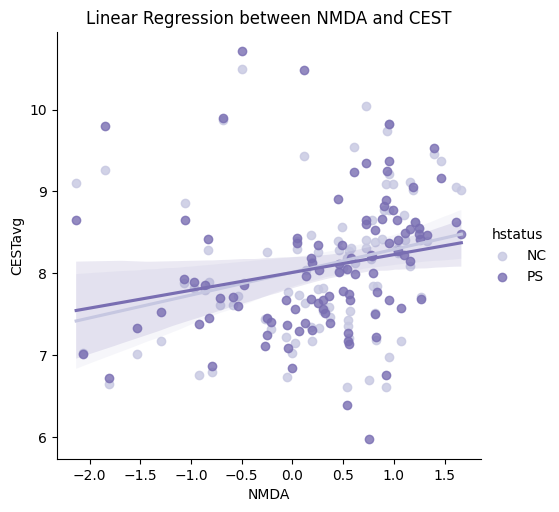

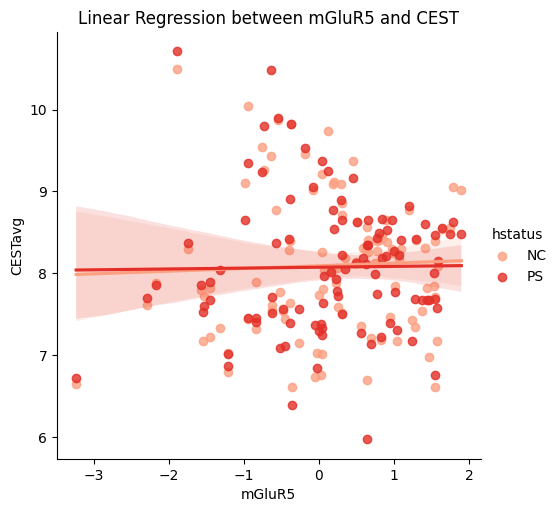

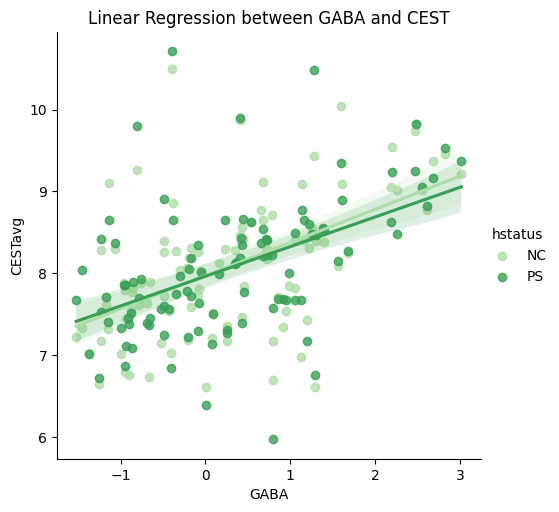

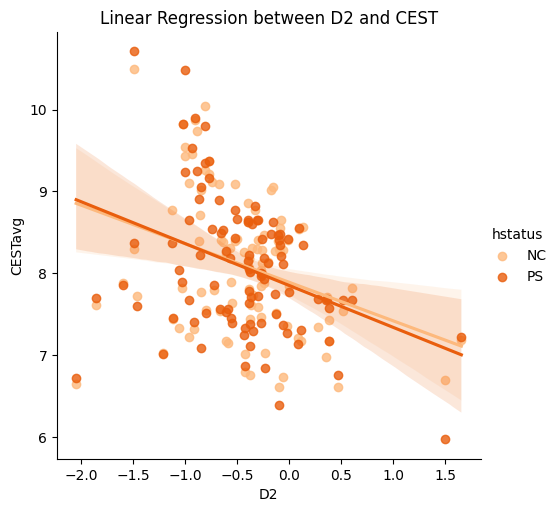

In [9]:
# Loop through nmaps and make correlation plots
#print(cestdf[CESTavg].max())

print(cestdf)
nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}

for nmap in nmaps:
    cestdf[nmap] = pd.to_numeric(cestdf[nmap], errors='coerce')
    cestdf['CESTavg'] = pd.to_numeric(cestdf['CESTavg'], errors='coerce')
    plot_data = cestdf.dropna(subset=[nmap, 'CESTavg'])
    palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
    plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 




In [45]:
schaefer_nifti = nib.load('/Users/pecsok/projects/Neuromaps/pecsok_pfns/neuromaps/data/test_masks/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_1mm.nii.gz')
schaefer_data = schaefer_nifti.get_fdata()

# CEST DATA
datapath = '/Users/pecsok/projects/Neuromaps/hansen_receptors/'
figpath = '/Users/pecsok/projects/GluCEST-fMRI/glucest-rsfmri/fmri_pipeline/parcellated_pipeline/figures'
cestavg_df = pd.DataFrame(index=range(1, 1001), columns=['CESTavg'])
cestavg_df['CESTavg'] = np.nan  # Initialize all values to 0
for _, row in cestdf.iterrows():
    # Extract parcel ID number using regex
    match = re.search(r'(\d+)', row['parcel'])
    if match:
        parcel_id = int(match.group(1))
        # Add CESTavg data to corresponding row in the new DataFrame
        if 1 <= parcel_id <= 1000:  # Ensure the parcel ID is within range
            cestavg_df.at[parcel_id, 'CESTavg'] = row['CESTavg']
            
for i, row in cestavg_df.iterrows():
    parcel_id = i
    value = row['CESTavg']
print(cestavg_df)

    
parcel_values = pd.DataFrame({
    'parcel_id': range(1, 1001),  # Parcel IDs should range from 1 to 1000
    'value': cestavg_df['CESTavg'] # np.random.rand(1000)  # Replace with your actual values
})
print(parcel_values)


# Create a copy of the Schaefer atlas array to modify
new_schaefer_data = np.zeros(schaefer_data.shape)

# Loop through each parcel and assign the corresponding value from your DataFrame
for i, row in parcel_values.iterrows():
    parcel_id = row['parcel_id']
    value = row['value']
    
    # Assign the value to all voxels belonging to the current parcel ID
    new_schaefer_data[schaefer_data == parcel_id] = value

# Create a new NIfTI image with the updated data
new_nifti = nib.Nifti1Image(new_schaefer_data, affine=schaefer_nifti.affine, header=schaefer_nifti.header)

# Save the new NIfTI file
new_nifti.to_filename('updated_schaefer_atlas.nii.gz')

      CESTavg
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
...       ...
996       NaN
997       NaN
998       NaN
999       NaN
1000      NaN

[1000 rows x 1 columns]
      parcel_id  value
1             1    NaN
2             2    NaN
3             3    NaN
4             4    NaN
5             5    NaN
...         ...    ...
996         996    NaN
997         997    NaN
998         998    NaN
999         999    NaN
1000       1000    NaN

[1000 rows x 2 columns]
